# Exploratory data analysis - geographic analysis and accident severity

This notebook explores two particular aspects of the data:
1. The spatial distribution of traffic accidents, including where the safest and most dangerous areas are
2. The characteristics of traffic accidents of different levels of severity

#### Importing the data and libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize': 14, 'figure.titlesize': 14, 'axes.labelsize': 13, })
import numpy as np
pd.set_option('display.max_columns', 50)
import geopandas as gpd
import seaborn as sns

Data sources used in this notebook:

[Traffic accidents in England and Wales](https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data)

[UK area classifications (LSOA to region)](https://geoportal.statistics.gov.uk/datasets/fe6c55f0924b4734adf1cf7104a0173e_0)

[UK Standard Area Measurements from the 2011 Census](https://geoportal.statistics.gov.uk/items/5a94044d113a4bd5bd895975d6612b05)

In [2]:
accidents = pd.read_csv('data/accidents/Accidents.csv')

## Where are the safest and most dangerous areas in England and Wales?

In [3]:
# Summary statistics
print("In 2013-2017 there were {:,} accidents in Great Britain.".format(len(accidents)))
print("The accidents involved a total of {:,} vehicles and {:,} people.".format(accidents['Number_of_Vehicles'].sum(), accidents['Number_of_Casualties'].sum()))
print("{:,} accidents ({}%) involved at least one fatality.".format(len(accidents[accidents.Accident_Severity == 'Fatal']), round(100*len(accidents[accidents.Accident_Severity == 'Fatal'])/len(accidents),1)))

In 2013-2017 there were 648,208 accidents in Great Britain.
The accidents involved a total of 1,194,834 vehicles and 860,369 people.
7,437 accidents (1.1%) involved at least one fatality.


The map below highlights the major cities with the greatest density of traffic accidents - particularly London, Birmingham, the area between Liverpool, Manchester, Leeds and Sheffield, and Newcastle.

The same is true for the density of fatal traffic accidents, as seen in the second map below.

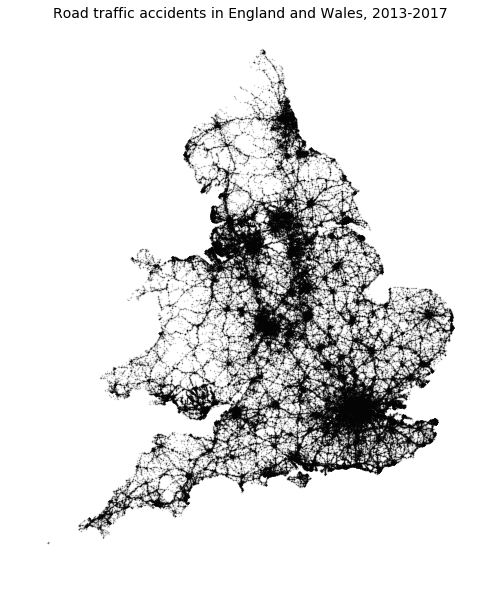

In [4]:
plt.figure(figsize=(8,10))
plt.scatter(accidents.Longitude, accidents.Latitude, s=0.2, alpha=0.2, color='black')
plt.title('Road traffic accidents in England and Wales, 2013-2017', fontsize=14)
plt.axis('off')
plt.show()

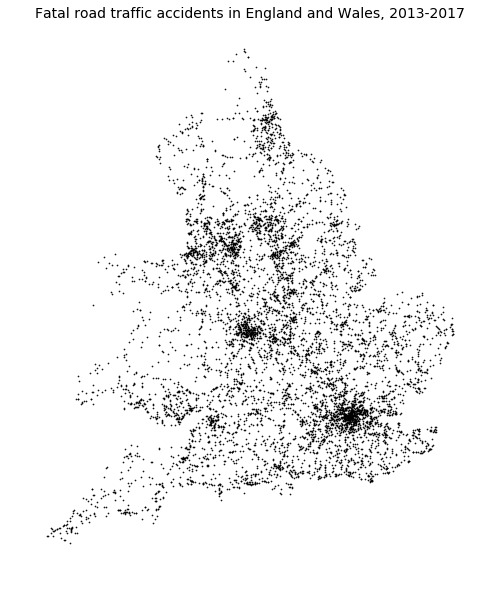

In [5]:
plt.figure(figsize=(8,10))
plt.scatter(accidents.Longitude[accidents.Accident_Severity == 'Fatal'], accidents.Latitude[accidents.Accident_Severity == 'Fatal'], s=0.5, alpha=0.9, color='black')
plt.title('Fatal road traffic accidents in England and Wales, 2013-2017', fontsize=14)
plt.axis('off')
plt.show()

**Unit of geographical analysis**

As explained in notebook 1 on cleaning and merging the traffic and population data, the geographic unit of analysis used in this project is the Lower Super Output Area (LSOA).

The following code calculates the accidents per area for each LSOA.

Process used below:
1. Import shapefiles for the boundaries of each LSOA
2. Combine the number of accidents, region name and size in hectares per LSOA
3. Add the shapefiles to the combined dataset
4. Calculate the accidents per area for each LSOA

In [6]:
# Step 1
# Importing the LSOA shapefile
lsoa_map = gpd.read_file('data/geography/LSOA_boundaries.shp')

# Dropping uncessary columns
lsoa_map.drop(['objectid', 'lsoa11nm', 'lsoa11nmw', 'st_areasha', 'st_lengths'], axis=1, inplace=True)

In [7]:
# Step 2
# Creating a dataframe of the number of accidents in each LSOA
lsoa_accidents = pd.DataFrame(accidents.groupby('LSOA_of_Accident_Location').size(), columns=['number_of_accidents']).reset_index()

# Importing a dataset of the geographic conversions (source: https://geoportal.statistics.gov.uk/datasets/fe6c55f0924b4734adf1cf7104a0173e_0)
oa_conversions = pd.read_csv('data/geography/UK_Output_Area_Conversions.csv', usecols=['LSOA11CD', 'RGN11NM']) 

# Adding the region name
lsoa_accidents = pd.merge(lsoa_accidents, oa_conversions, how='left', left_on='LSOA_of_Accident_Location', right_on='LSOA11CD').drop_duplicates()

# Adding the number of hectares (source: https://geoportal.statistics.gov.uk/items/5a94044d113a4bd5bd895975d6612b05)
lsoa_sizes = pd.read_csv('data/geography/UK_LSOA_Standard_Area_Measurements.csv', usecols=['LSOA11CD', 'AREAEHECT'])
lsoa_accidents = pd.merge(lsoa_accidents, lsoa_sizes, how='left', left_on='LSOA_of_Accident_Location', right_on='LSOA11CD').drop_duplicates()
lsoa_accidents.drop(['LSOA11CD_x', 'LSOA11CD_y'], axis=1, inplace=True)

In [8]:
# Step 3
# Adding the accident counts to the LSOA boundary dataframe
lsoa_accidents = pd.merge(lsoa_map, lsoa_accidents, how='left', left_on='lsoa11cd', right_on='LSOA_of_Accident_Location')

# Dropping extra LSOA column and replacing null counts with 0
lsoa_accidents.drop(['LSOA_of_Accident_Location'], axis=1, inplace=True)
lsoa_accidents.number_of_accidents.fillna(0, inplace=True)

In [9]:
# Step 4
# Adding the number of accidents per hectare
lsoa_accidents['accidents_per_hectare'] = lsoa_accidents.number_of_accidents/lsoa_accidents.AREAEHECT
lsoa_accidents.drop('AREAEHECT', axis=1, inplace=True)

- Most LSOAs have an average of 0-5 traffic accidents per year
- 475 (1.4%) of LSOAs had no traffic accidents at all over the five year period 2013-2017
- The average number of accidents per year ranged up to 221 in some areas

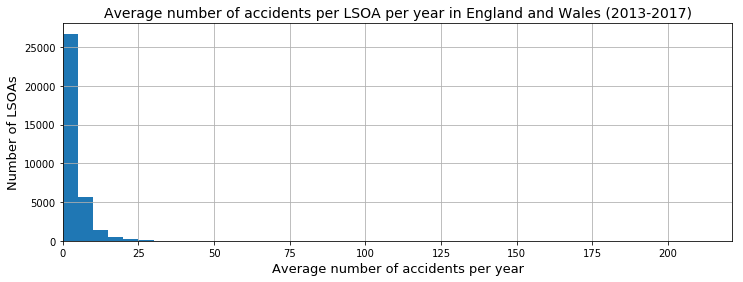

In [10]:
plt.figure(figsize=(12,4))
binwidth = 5
(lsoa_accidents.number_of_accidents/5).hist(bins=np.arange(min(lsoa_accidents.number_of_accidents), max(lsoa_accidents.number_of_accidents) + binwidth, binwidth))
plt.title('Average number of accidents per LSOA per year in England and Wales (2013-2017)', fontsize=14)
plt.xlim(0, max((lsoa_accidents.number_of_accidents/5)))
plt.xlabel('Average number of accidents per year', fontsize=13)
plt.ylabel('Number of LSOAs', fontsize=13)
plt.show()

In [11]:
print("Number of LSOAs with no traffic accidents between 2013 and 2017: {} ({}%)"
      .format(len(lsoa_accidents[lsoa_accidents.number_of_accidents == 0]),
             round(100*len(lsoa_accidents[lsoa_accidents.number_of_accidents == 0])/len(lsoa_accidents),1)))
print("Highest average number of accidents per year:", round(max(lsoa_accidents.number_of_accidents)/5))

Number of LSOAs with no traffic accidents between 2013 and 2017: 475 (1.4%)
Highest average number of accidents per year: 221


The map below shows that the LSOAs with the most accidents tend to be the largest. They are large because they are sparsely populated - LSOAs are based on population size rather than physical size. They are likely to contain large main roads which go between different towns or cities.

To show differences in accident numbers more clearly, the areas with the highest and lowest densities of accidents per hectare will be shown below that.

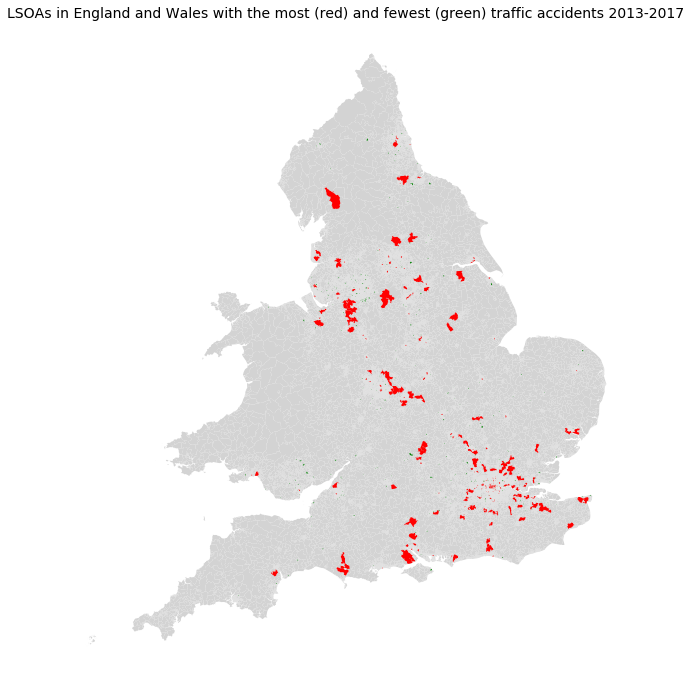

In [12]:
# Creating lists of the LSOAs with the most and fewest traffic accidents
worst_lsoas = lsoa_accidents.sort_values(by=['number_of_accidents'], ascending=False)[:300]
best_lsoas = lsoa_accidents.sort_values(by=['number_of_accidents'])[:300]

# Mapping
fig, ax = plt.subplots(1, figsize=(30, 12))
lsoa_accidents.plot(color='lightgrey', ax=ax, linewidth=0)
worst_lsoas.plot(color='red', ax=ax, linewidth=0)
best_lsoas.plot(color='green', ax=ax, linewidth=0)
ax.axis('off')
ax.set_title('LSOAs in England and Wales with the most (red) and fewest (green) traffic accidents 2013-2017', fontsize=14)
plt.show()

When the size of LSOAs is taken into account, a very different pattern emerges. The areas with the highest densities of traffic accidents are in densely-populated cities - primarily in London, which contains 95% of the 300 worst areas. The areas with the lowest densities of traffic accidents are in rural areas - primarily in Wales, which contains 30% of the best areas, as well as north close to the border with Scotland.

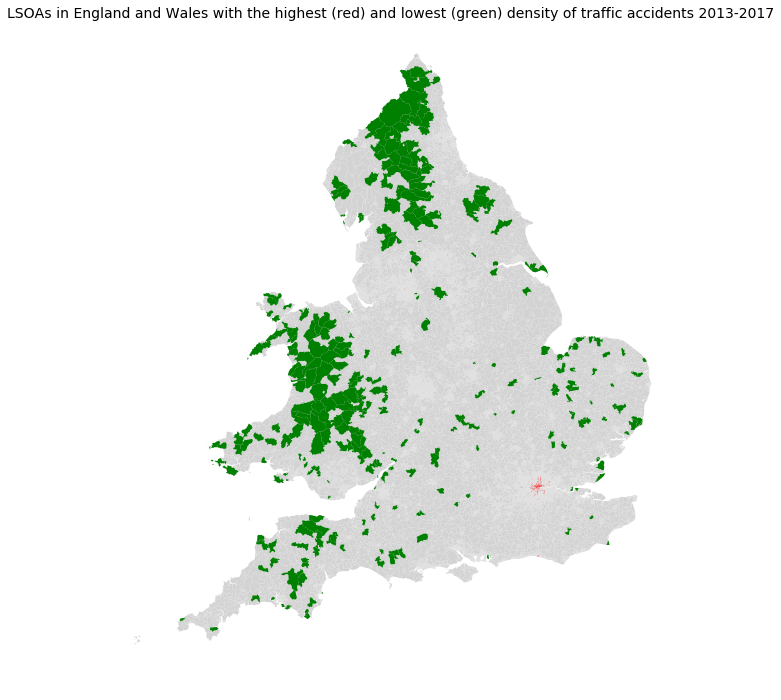

In [16]:
# Creating lists of the LSOAs with the highest and lowest density of traffic accidents
worst_lsoas = lsoa_accidents.sort_values(by=['accidents_per_hectare'], ascending=False)[:300]
best_lsoas = lsoa_accidents.sort_values(by=['accidents_per_hectare'])[:300]

# Mapping
fig, ax = plt.subplots(1, figsize=(30, 12))
lsoa_accidents.plot(color='lightgrey', ax=ax, linewidth=0)
worst_lsoas.plot(color='red', ax=ax, linewidth=0)
best_lsoas.plot(color='green', ax=ax, linewidth=0)
ax.axis('off')
ax.set_title('LSOAs in England and Wales with the highest (red) and lowest (green) density of traffic accidents 2013-2017', fontsize=14)
plt.show()

In [14]:
# Proportion of the 300 LSOAs with the highest densities of traffic accidents in different regions of the UK
worst_lsoas.RGN11NM.value_counts(normalize=True)

London                      0.950000
South East                  0.020000
Yorkshire and The Humber    0.013333
East Midlands               0.010000
North West                  0.003333
North East                  0.003333
Name: RGN11NM, dtype: float64

In [15]:
# Proportion of the 300 LSOAs with the lowest densities of traffic accidents in different regions of the UK
best_lsoas.RGN11NM.value_counts(normalize=True)

Wales                       0.300000
South West                  0.180000
East of England             0.140000
North West                  0.090000
West Midlands               0.080000
Yorkshire and The Humber    0.076667
North East                  0.073333
South East                  0.030000
East Midlands               0.030000
Name: RGN11NM, dtype: float64

## What are the characteristics of the worst accidents?

Accidents are classified into severity based on the severity of the most severely injured casualty:
- Slight: An injury of a minor character such as a sprain (including neck whiplash injury), bruise or cut which are not judged to be severe, or slight shock requiring roadside attention. This definition includes injuries not requiring medical treatment.
- Serious: An injury for which a person is detained in hospital as an 'in-patient', or any of the following injuries whether or not they are detained in hospital: fractures, concussion, internal injuries, crushings, burns (excluding friction burns), severe cuts, severe general shock requiring medical treatment and injuries causing death 30 or more days after the accident. An injured casualty is recorded as seriously or slightly injured by the police on the basis of information available within a short time of the accident. This generally will not reflect the results of a medical examination, but may be influenced according to whether the casualty is hospitalised or not. Hospitalisation procedures will vary regionally.
- Fatal: A casualty died at the scene, or within 30 days of the accident as a result of injuries from the accident.

[Source: Reported Road Casualties in Great Britain: notes, definitions, symbols and conventions](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/743853/reported-road-casualties-gb-notes-definitions.pdf)

In 84% of accidents, only slight injuries were sustained by the casualties involved. 15% involved the hospitalisation of at least one casualty, but no fatalities within 30 days of the accident. 1% of accidents involved at least one fatality either at the scene or within 30 days.

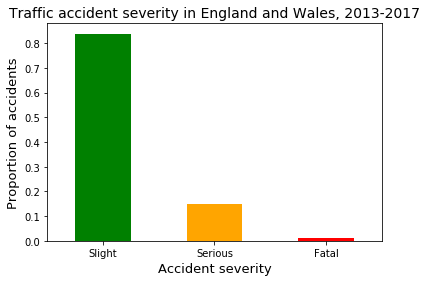

In [46]:
accidents.Accident_Severity.value_counts(normalize=True).plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Traffic accident severity in England and Wales, 2013-2017', fontsize=14)
plt.xlabel('Accident severity', fontsize=13)
plt.ylabel('Proportion of accidents', fontsize=13)
plt.xticks(rotation=0)
plt.show()

In [21]:
accidents.Accident_Severity.value_counts(normalize=True)

Slight     0.838485
Serious    0.150041
Fatal      0.011473
Name: Accident_Severity, dtype: float64

**The analysis below compares the characteristics of the three types of accidents.**

**Numbers of casualties and vehicles**

The boxplots below show that there is not much difference between the average number of casualties and vehicles per accident severity type, although fatal accidents do tend to involve a slightly higher number of casualties on average.

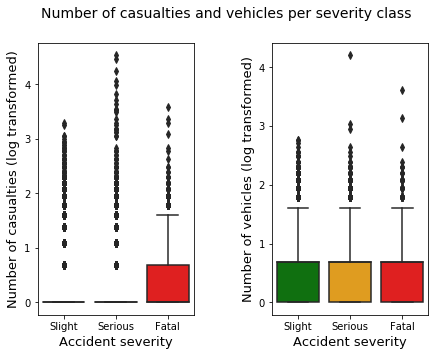

In [98]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7,5))
plt.suptitle('Number of casualties and vehicles per severity class')
order = ['Slight', 'Serious', 'Fatal']
palette = {'Slight': 'green', 'Serious': 'orange', 'Fatal': 'red'}

sns.boxplot(x=accidents.Accident_Severity, y=accidents.log_Number_of_Casualties, order=order, palette=palette, ax=ax1)
ax1.set_xlabel('Accident severity')
ax1.set_ylabel('Number of casualties (log transformed)')

sns.boxplot(x=accidents.Accident_Severity, y=accidents.log_Number_of_Vehicles, order=order, palette=palette, ax=ax2)
ax2.set_xlabel('Accident severity')
ax2.set_ylabel('Number of vehicles (log transformed)')

plt.subplots_adjust(wspace=0.5)
plt.show()

In [81]:
accidents.groupby('Accident_Severity')['Number_of_Casualties'].mean()

Accident_Severity
Fatal      1.750840
Serious    1.398363
Slight     1.308793
Name: Number_of_Casualties, dtype: float64

**Road class, type and junctions**

- Fatal accidents occur in higher proportions on A roads, motorways and dual carriageways (larger, faster roads), and in lower proportions on unclassified and slip roads (smaller, slower roads) and roundabouts.
- For example, an accident on a motorway and/or a dual carriageway has a 1.6% chance of having fatalities, whereas an accident on an unclassified road has a 0.7% chance and an accident on a roundabout has a 0.3% chance.
- Slight and serious accidents occur in similar proportions on different road classes and types.
- Fatal accidents are much less likely to occur at junctions (presumably because this implies a lower speed). Accidents at junctions are more likely to only be slight.

Road class:

In [116]:
# Combining A(M) (motorway sections of A roads) into the motorway category
accidents['1st_Road_Class'].replace('A(M)', 'Motorway', inplace=True)
accidents['2nd_Road_Class'].replace('A(M)', 'Motorway', inplace=True)

In [144]:
# Creating a pivot table of accident proportions by road type
accidents_by_road = accidents.groupby('Accident_Severity')['1st_Road_Class'].value_counts(normalize=True).unstack()
accidents_by_road = accidents_by_road[['A', 'Unclassified', 'B', 'C', 'Motorway']].sort_index(ascending=False)
accidents_by_road

1st_Road_Class,A,Unclassified,B,C,Motorway
Accident_Severity,,,,,
Slight,0.456824,0.303060,0.119631,0.080629,0.039856
Serious,0.440838,0.315213,0.136945,0.077485,0.029519
Fatal,0.556676,0.188248,0.129219,0.071400,0.054457


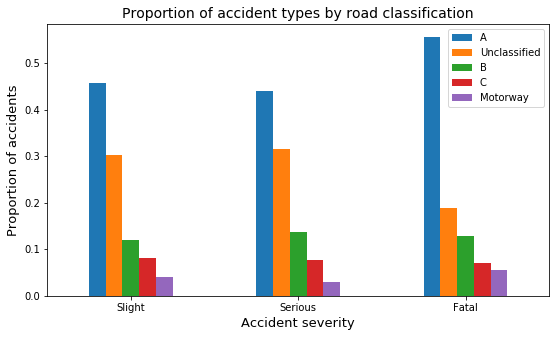

In [257]:
accidents_by_road.plot(figsize=(9,5), kind='bar')
plt.title('Proportion of accident types by road classification')
plt.xlabel('Accident severity')
plt.ylabel('Proportion of accidents')
plt.xticks(rotation=0)
plt.legend();

In [304]:
def probability_of_accident_severity(col):
    """Produces a table of the proportion of accidents in each category of col that were fatal, serious or slight"""
    return accidents.groupby(col)['Accident_Severity'].value_counts(normalize=True).unstack()

In [305]:
probability_of_accident_severity('1st_Road_Class')

Accident_Severity,Fatal,Serious,Slight
1st_Road_Class,,,
A,0.014020,0.145190,0.840790
B,0.012118,0.167955,0.819927
C,0.010233,0.145230,0.844537
Motorway,0.016240,0.115126,0.868634
Unclassified,0.007115,0.155798,0.837087


Road type:

In [146]:
# Creating a pivot table of accident proportions by road type
accidents_by_road_type = accidents.groupby('Accident_Severity')['Road_Type'].value_counts(normalize=True).unstack()
accidents_by_road_type = accidents_by_road_type[['Single carriageway', 'Dual carriageway', 'Roundabout', 'One way street', 'Slip road']].sort_index(ascending=False)
accidents_by_road_type

Road_Type,Single carriageway,Dual carriageway,Roundabout,One way street,Slip road
Accident_Severity,,,,,
Slight,0.745868,0.148403,0.072320,0.022126,0.011282
Serious,0.793395,0.129110,0.049466,0.020646,0.007382
Fatal,0.764825,0.200619,0.015867,0.012236,0.006454


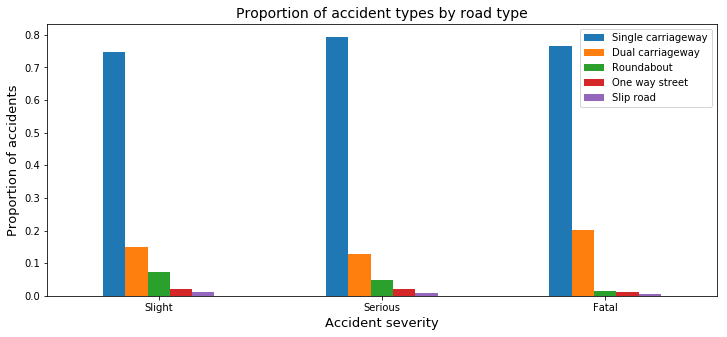

In [258]:
accidents_by_road_type.plot(figsize=(12,5), kind='bar')
plt.title('Proportion of accident types by road type')
plt.xlabel('Accident severity')
plt.ylabel('Proportion of accidents')
plt.xticks(rotation=0)
plt.legend();

In [306]:
# Probabilities of accidents being fatal, serious or slight given the road they occur on
probability_of_accident_severity('Road_Type')

Accident_Severity,Fatal,Serious,Slight
Road_Type,,,
Dual carriageway,0.015754,0.132586,0.851660
One way street,0.006443,0.142169,0.851388
Roundabout,0.002668,0.108758,0.888575
Single carriageway,0.011650,0.158046,0.830304
Slip road,0.006959,0.104088,0.888953


Junction proximity:

In [284]:
def unsorted_severity_category_plot(col, title='Proportion of accidents by severity', figsize=(10,5)):
    """Plots a bar chart of the proportions of the specified column for each accident severity category"""
    accidents.groupby('Accident_Severity')[col].value_counts(normalize=True).unstack().sort_index(ascending=False).plot(figsize=figsize, kind='bar')
    plt.title(title)
    plt.xlabel('Accident severity')
    plt.ylabel('Proportion of accidents')
    plt.xticks(rotation=0)
    plt.legend();

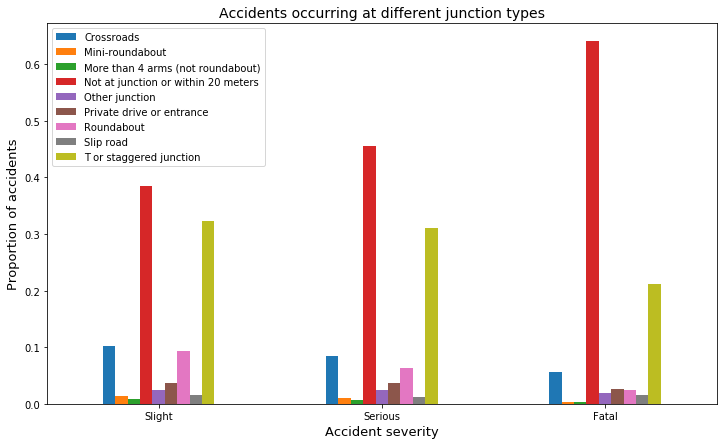

In [290]:
unsorted_severity_category_plot('Junction_Detail', figsize=(12,7), title='Accidents occurring at different junction types')

In [307]:
# Probabilities of accidents being fatal, serious or slight given the junction type
probability_of_accident_severity('Junction_Detail')

Accident_Severity,Fatal,Serious,Slight
Junction_Detail,,,
Crossroads,0.006609,0.127473,0.865918
Mini-roundabout,0.003056,0.109779,0.887165
More than 4 arms (not roundabout),0.004340,0.118868,0.876792
Not at junction or within 20 meters,0.018482,0.171606,0.809913
Other junction,0.009368,0.150092,0.840540
Private drive or entrance,0.008073,0.155105,0.836822
Roundabout,0.003195,0.106358,0.890447
Slip road,0.012090,0.117984,0.869927
T or staggered junction,0.007597,0.145583,0.846821


**Speed limit**

The top graph below shows that most accidents occur on roads with a speed limit of 30mph, followed by 60mph.

The table and graph below confirm the results of the analysis of road types, that fatal accidents tend to occur on faster roads. The median speed limit for fatal accidents is 50mph, compared to 30mph for slight and serious accidents. This is because the road speed limit is a proxy for the speed of the vehicles, and fatalities are more likely at higher speeds.

Interestingly, this pattern does not hold for roads with a speed limit of 70mph, where there are a greater proportion of less severe accidents than would be expected. Possibly these are accidents occurring at lower speeds on these high speed roads (motorways and dual carriageways), e.g. due to roadworks.

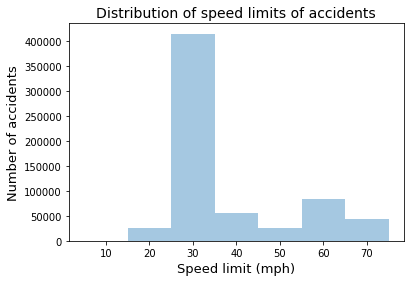

In [242]:
bins = list(range(5,76,10))
sns.distplot(accidents.Speed_limit, bins=bins, kde=False)
plt.title('Distribution of speed limits of accidents')
plt.xlabel('Speed limit (mph)')
plt.ylabel('Number of accidents')
plt.xticks(rotation=0)
plt.show()

In [213]:
# Dropping the three accidents with 0 or 10 mph, as this may be data entry error
accidents.drop(accidents[accidents.Speed_limit < 20].index, inplace=True)

# Converting to integers
accidents.Speed_limit = accidents.Speed_limit.astype('int64')

In [236]:
# Median road speed limit for different accident types
accidents.groupby('Accident_Severity')['Speed_limit'].median()

Accident_Severity
Fatal      50
Serious    30
Slight     30
Name: Speed_limit, dtype: int64

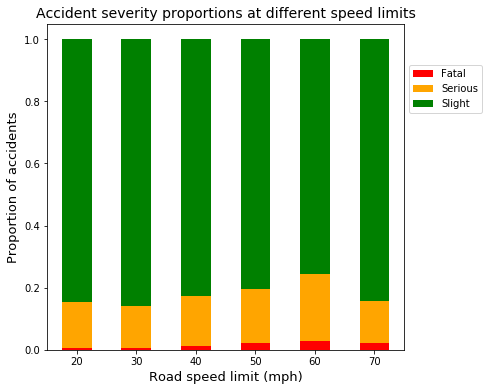

In [243]:
fig, ax = plt.subplots(1, figsize=(8,6))

accidents.groupby('Speed_limit')['Accident_Severity'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, color=['red', 'orange', 'green'], ax=ax)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))

ax.set_title('Accident severity proportions at different speed limits')
ax.set_xlabel('Road speed limit (mph)')
ax.set_ylabel('Proportion of accidents')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()

**Light, weather and road conditions**

- Fatal accidents are much more likely to occur in dark conditions with no lighting - 4.1% of accidents in the dark with no lighting were fatal, compared to 0.9% of accidents in daylight.
- Weather conditions and road surface conditions have less of a notable effect on accident severity than light conditions.
- Interestingly, accidents in snowy conditions are less likely to result in fatalities - presumably because traffic tends to be travelling more slowly in the snow.

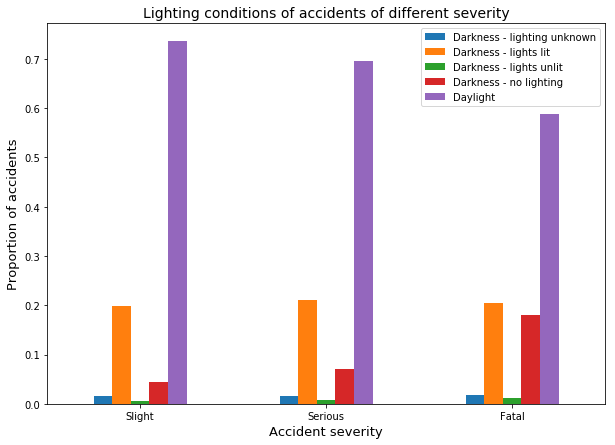

In [292]:
unsorted_severity_category_plot('Light_Conditions', figsize=(10,7), title='Lighting conditions of accidents of different severity')

In [308]:
probability_of_accident_severity('Light_Conditions')

Accident_Severity,Fatal,Serious,Slight
Light_Conditions,,,
Darkness - lighting unknown,0.012550,0.143993,0.843457
Darkness - lights lit,0.011707,0.157252,0.831040
Darkness - lights unlit,0.021211,0.177186,0.801604
Darkness - no lighting,0.041376,0.214841,0.743783
Daylight,0.009259,0.143537,0.847204


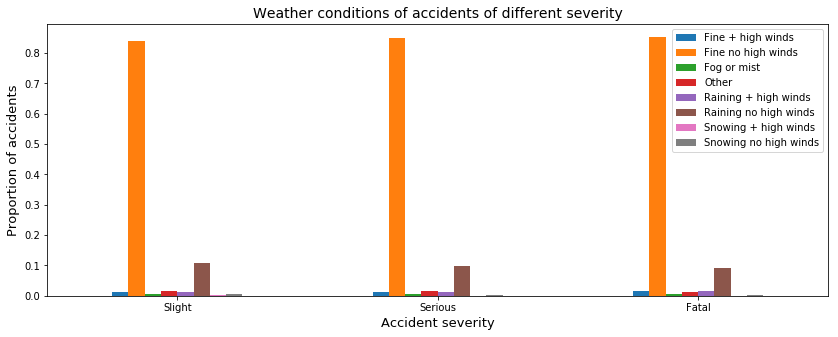

In [295]:
unsorted_severity_category_plot('Weather_Conditions', figsize=(14,5), title='Weather conditions of accidents of different severity')

In [309]:
probability_of_accident_severity('Weather_Conditions')

Accident_Severity,Fatal,Serious,Slight
Weather_Conditions,,,
Fine + high winds,0.015295,0.160469,0.824235
Fine no high winds,0.011649,0.151892,0.836459
Fog or mist,0.016718,0.173684,0.809598
Other,0.009068,0.135098,0.855834
Raining + high winds,0.013259,0.149982,0.836760
Raining no high winds,0.009762,0.137795,0.852443
Snowing + high winds,0.004016,0.097724,0.898260
Snowing no high winds,0.009797,0.114189,0.876014


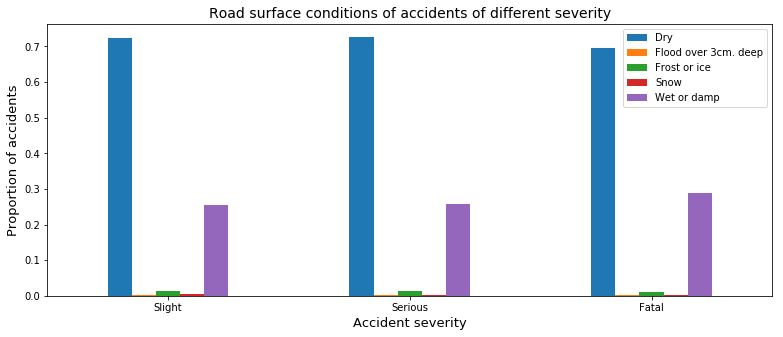

In [299]:
unsorted_severity_category_plot('Road_Surface_Conditions', figsize=(13,5), title='Road surface conditions of accidents of different severity')

In [310]:
probability_of_accident_severity('Road_Surface_Conditions')

Accident_Severity,Fatal,Serious,Slight
Road_Surface_Conditions,,,
Dry,0.011014,0.150490,0.838496
Flood over 3cm. deep,0.018205,0.148244,0.833550
Frost or ice,0.010070,0.136909,0.853021
Snow,0.007014,0.100406,0.892580
Wet or damp,0.012887,0.150292,0.836821


**Urban or rural**

Urban areas are classified as those within an area of population of 10,000 or more.

Fatal accidents are much more likely to occur in rural areas. This is primarily because fatal accidents are more likely to occur on major A roads and motorways, which span between urban areas rather than running through them.

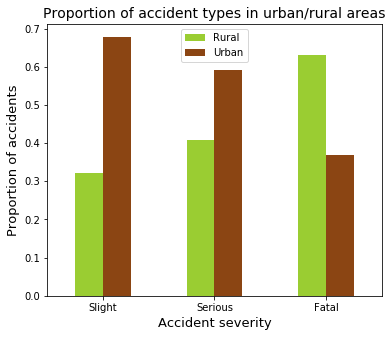

In [262]:
accidents.groupby('Accident_Severity')['Urban_or_Rural_Area'].value_counts(normalize=True).unstack().sort_index(ascending=False).plot(figsize=(6,5), kind='bar', color=['yellowgreen', 'saddlebrown'])
plt.title('Proportion of accident types in urban/rural areas')
plt.xlabel('Accident severity')
plt.ylabel('Proportion of accidents')
plt.xticks(rotation=0)
plt.legend();

## Summary

- **Major densely-populated cities have the greatest number and density of traffic accidents and fatalities**, particularly London (containing 95% of the 300 worst LSOAs), and also Birmingham, the area between Liverpool, Manchester, Leeds and Sheffield, and Newcastle. The areas with the lowest densities of traffic accidents are in rural areas - primarily in Wales, which contains 30% of the best areas, as well as north close to the border with Scotland.
- In 84% of accidents, only slight injuries were sustained by the casualties involved. 15% involved the hospitalisation of at least one casualty, but no fatalities within 30 days of the accident. **1% of accidents involved at least one fatality** either at the scene or within 30 days.
- There is not much difference between the average number of casualties and vehicles per accident severity type.
- **Fatal accidents occur in higher proportions on A roads, motorways and dual carriageways** (larger, faster roads), and in lower proportions on unclassified and slip roads (smaller, slower roads) and roundabouts. For example, an accident on a motorway and/or a dual carriageway has a 1.6% chance of having fatalities, whereas an accident on an unclassified road has a 0.7% chance and an accident on a roundabout has a 0.3% chance.
- Fatal accidents are much less likely to occur at junctions (presumably because this implies a lower speed). **Accidents at junctions are more likely to only be slight**.
- **Fatal accidents tend to occur on faster roads**. The median speed limit for fatal accidents is 50mph, compared to 30mph for slight and serious accidents. This is because the road speed limit is a proxy for the speed of the vehicles, and fatalities are more likely at higher speeds.
- **Fatal accidents are much more likely to occur in dark conditions with no lighting** - 4.1% of accidents in the dark with no lighting were fatal, compared to 0.9% of accidents in daylight. **Weather conditions and road surface conditions have less of a notable effect** on accident severity than light conditions.
- Interestingly, **accidents in snowy conditions are less likely to result in fatalities** - presumably because traffic tends to be travelling more slowly in the snow.
- **Fatal accidents are much more likely to occur in rural areas**. This is primarily because fatal accidents are more likely to occur on major A roads and motorways, which span between urban areas rather than running through them.